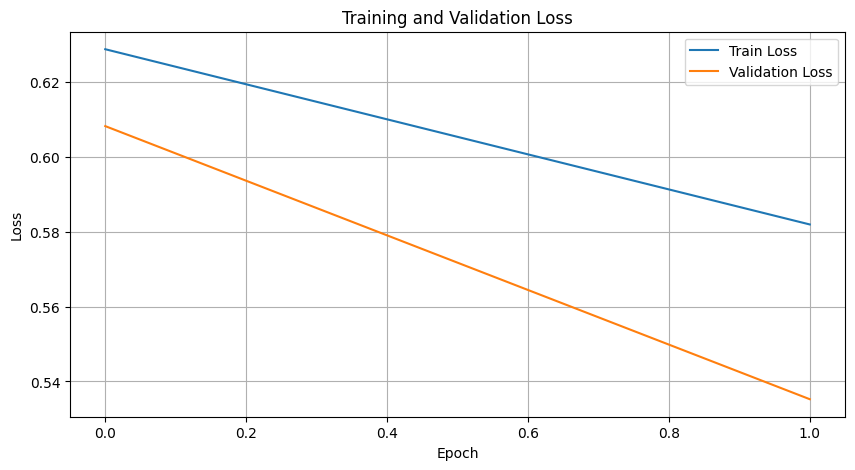

Train Loss=0.5819, Val Loss=0.5353

Predicted label distribution: (array([0]), array([31]))
True label distribution: (array([0]), array([31]))
Val Accuracy: 1.000, F1 Score: 0.000
Sample Predictions vs Targets:
Pred: 0.42, Target: 0
Pred: 0.41, Target: 0
Pred: 0.42, Target: 0
Pred: 0.42, Target: 0
Pred: 0.42, Target: 0
Pred: 0.41, Target: 0
Pred: 0.42, Target: 0
Pred: 0.41, Target: 0
Pred: 0.42, Target: 0
Pred: 0.41, Target: 0


In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pydicom
import nibabel as nib
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ----------------------------
# 1. SCAN LOADING & PREPROCESSING
# ----------------------------
import pathlib

def load_scan(file_path):
    file_path = str(pathlib.Path(file_path))
    if file_path.endswith('.nii') or file_path.endswith('.nii.gz'):
        img = nib.load(file_path)
        return img.get_fdata()
    elif os.path.isdir(file_path):
        slices = [pydicom.dcmread(os.path.join(file_path, f)) for f in os.listdir(file_path) if f.endswith('.dcm')]
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        volume = np.stack([s.pixel_array for s in slices], axis=-1)
        return volume
    else:
        raise ValueError(f"Unsupported format or bad path: {file_path}")

def normalize_volume(volume):
    volume = volume.astype(np.float32)
    volume -= np.min(volume)
    volume /= np.max(volume)
    return volume

def extract_12_slices(volume):
    slices = []
    z_len = volume.shape[2]
    axial_indices = np.linspace(0, z_len - 1, 10, dtype=int)
    axial_slices = [volume[:, :, idx] for idx in axial_indices]
    coronal_idx = volume.shape[1] // 2
    coronal_slice = volume[:, coronal_idx, :]
    sagittal_idx = volume.shape[0] // 2
    sagittal_slice = volume[sagittal_idx, :, :]
    slices.extend(axial_slices)
    slices.append(coronal_slice)
    slices.append(sagittal_slice)
    return slices

def preprocess_scan(path, target_size=(224, 224)):
    volume = load_scan(path)
    volume = normalize_volume(volume)
    slices = extract_12_slices(volume)
    resized = [cv2.resize(s, target_size, interpolation=cv2.INTER_AREA) for s in slices]
    return np.stack(resized, axis=0)

# ----------------------------
# 2. DATASET CLASS
# ----------------------------
class CTADataset(Dataset):
    def __init__(self, labels_csv, root_dir, transform=None):
        self.data = pd.read_csv(labels_csv)
        self.root_dir = root_dir
        self.transform = transform
        self.data['label'] = self.data['label'].apply(lambda x: 1 if x >= 3 else 0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data.iloc[idx]
        filename = entry['filename']
        scan_id = filename.split('-')[1].split()[0]
        file_path = os.path.join(self.root_dir, scan_id, '20', filename)
        slices = preprocess_scan(file_path)
        slices = torch.tensor(slices).unsqueeze(1).float()
        if self.transform:
            slices = self.transform(slices)
        label = torch.tensor(entry['label']).float()
        return slices, label

# ----------------------------
# 3. MODEL DEFINITION
# ----------------------------
class SliceCNN(nn.Module):
    def __init__(self, feature_dim=128):
        super(SliceCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(128, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class CTAQuality2D(nn.Module):
    def __init__(self, feature_dim=128):
        super(CTAQuality2D, self).__init__()
        self.slice_cnn = SliceCNN(feature_dim)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        B, S, C, H, W = x.shape
        x = x.view(B * S, C, H, W)
        feats = self.slice_cnn(x)
        feats = feats.view(B, S, -1)
        pooled = feats.mean(dim=1)
        out = self.classifier(pooled)
        return torch.sigmoid(out.squeeze(1))

# ----------------------------
# 4. TRAINING AND EVALUATION
# ----------------------------
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    loop = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        loop.set_postfix(loss=loss.item())
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds.append(outputs.cpu())
            targets.append(labels.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return total_loss / len(dataloader.dataset), preds, targets

# ----------------------------
# 5. TRAINING DRIVER
# ----------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root_dir = "C:\\Users\\HenryLi\\Downloads\\Scans"
labels_csv = "C:/Users/HenryLi/Desktop/Python Projects/CTA Scan Binary Classifier/Labels.csv"
batch_size = 8
num_epochs = 2

# Check label distribution before splitting
df = pd.read_csv(labels_csv)
df['label'] = df['label'].apply(lambda x: 1 if x >= 3 else 0)
print("Label distribution before split:\n", df['label'].value_counts())

# Stratified split to maintain class balance in train and val
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print("\nTrain label distribution:\n", train_df['label'].value_counts())
print("Validation label distribution:\n", val_df['label'].value_counts())

train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)

train_loader = DataLoader(CTADataset('train.csv', root_dir), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(CTADataset('val.csv', root_dir), batch_size=batch_size)

model = CTAQuality2D().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses, val_losses = [], []
best_val_loss = float('inf')
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_preds, val_targets = evaluate(model, val_loader, criterion)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    preds_bin = (val_preds.numpy() > 0.5).astype(int)
    targets_bin = val_targets.numpy().astype(int)
    print("\nPredicted label distribution:", np.unique(preds_bin, return_counts=True))
    print("True label distribution:", np.unique(targets_bin, return_counts=True))
    acc = accuracy_score(targets_bin, preds_bin)
    f1 = f1_score(targets_bin, preds_bin, zero_division=0)
    print(f"Val Accuracy: {acc:.3f}, F1 Score: {f1:.3f}")

    # Live loss curve
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print AFTER plot
    print(f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    print("\nPredicted label distribution:", np.unique(preds_bin, return_counts=True))
    print("True label distribution:", np.unique(targets_bin, return_counts=True))
    print(f"Val Accuracy: {acc:.3f}, F1 Score: {f1:.3f}")
# Sample predictions
print("Sample Predictions vs Targets:")
for pred, target in zip(val_preds[:10], val_targets[:10]):
    print(f"Pred: {pred.item():.2f}, Target: {target.item():.0f}")

